In [69]:
import numpy as np
import os
import random
import glob
import pandas as pd
import time
import sklearn as sk
import matplotlib.pyplot as plt
import importlib
from common import common
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from concurrent.futures import ProcessPoolExecutor
from functools import partial

In [70]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/Users/suyeetan/Downloads/CS5344_Project/work/common/common.py'>

In [71]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'
TEST_COUNT = 500

In [72]:
# %run datasets/covertype.ipynb
%run datasets/kdd.ipynb
# %run datasets/cicids.ipynb
# %run datasets/unsw.ipynb
# %run datasets/thyroid.ipynb

In [73]:
# Should already be one hot encoded and label encoded
# all_df, main_labels, config = get_processed_covtype_df()
all_df, main_labels, config = get_processed_kdd_df()
# all_df, main_labels, config = get_processed_cicids_df()
# all_df, main_labels, config = get_processed_unsw_df()
# all_df, main_labels, config = get_processed_thyroid_df()
TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

Normal class:  0    smurf.
Name: attack, dtype: object
TARGET_DICT {0: 'apache2', 1: 'back', 2: 'buffer_overflow', 3: 'ftp_write', 4: 'guess_passwd', 5: 'httptunnel', 6: 'imap', 7: 'ipsweep', 8: 'land', 9: 'loadmodule', 10: 'mailbomb', 11: 'mscan', 12: 'multihop', 13: 'named', 14: 'neptune', 15: 'nmap', 16: 'normal', 17: 'perl', 18: 'phf', 19: 'pod', 20: 'portsweep', 21: 'processtable', 22: 'ps', 23: 'rootkit', 24: 'saint', 25: 'satan', 26: 'sendmail', 27: 'smurf', 28: 'snmpgetattack', 29: 'snmpguess', 30: 'sqlattack', 31: 'teardrop', 32: 'udpstorm', 33: 'warezmaster', 34: 'worm', 35: 'xlock', 36: 'xsnoop', 37: 'xterm'}
NORMAL_TARGET 16
main_labels ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate'

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,105,146,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,105,146,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,105,146,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,105,146,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,105,146,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [74]:
all_df.shape

(311029, 118)

In [75]:
# Create a folder to save the CSVs
common.remove_files_from_directory(OUTPUT_FOLDER)
common.remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [76]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [77]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(248823, 117) (62206, 117) (248823,) (62206,)


In [78]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack
147391,0,226,3861,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16
107622,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
53448,0,1032,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27
3099,0,1032,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27
208489,0,1032,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27


In [79]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

In [80]:
# Loop through each cover type and create a dataset
benign = 2359289
abnormal_type_counts = all_df[TARGET_COLUMN].value_counts()
abnormal_type_dict = abnormal_type_counts.to_dict()
print('abnormal_type_dict', abnormal_type_dict)
target_index = all_df.columns.get_loc(TARGET_COLUMN)
benign_ratio = 2  # Adjust this ratio as needed
min_benign_samples = 50  # Ensure at least 50 benign samples are always included

for label, name in TARGET_DICT.items():
    if label == NORMAL_TARGET:
        continue  # Skip the normal target
    
    a, b = 0, 0  # Track abnormal and benign sample counts
    
    # Open the output file for writing
    output_path = os.path.join(OUTPUT_FOLDER, f"{name}.csv")
    with open(output_path, "w") as ths:
        ths.write(','.join(main_labels) + "\n")
        
        # Calculate the number of benign samples based on the fixed ratio
        abnormal_count = abnormal_type_dict[label]
        benign_num = max(min(int(abnormal_count * benign_ratio), benign), min_benign_samples)
        # print(f'Creating {name}.csv with {benign_num} benign samples and {abnormal_count} abnormal samples.')

        # Collect normal (benign) rows and abnormal rows
        benign_rows = []
        abnormal_rows = []

        # Read all_data.csv line by line and collect rows
        with open("all_data.csv", "r") as file:
            for i, line in enumerate(file):
                if i == 0:
                    continue  # Skip the header row
                k = line.strip().split(",")  # Strip newline and split the line
                
                # Collect normal rows
                if int(k[target_index]) == NORMAL_TARGET:
                    benign_rows.append(line)
                
                # Collect abnormal rows that match the current label
                elif int(k[target_index]) == label:
                    abnormal_rows.append(line)

        # Randomly sample benign rows
        if len(benign_rows) > benign_num:
            benign_rows = random.sample(benign_rows, benign_num)
        else:
            benign_rows = random.sample(benign_rows, len(benign_rows))  # Shuffle if fewer than required

        # Concatenate benign and abnormal rows
        combined_rows = benign_rows + abnormal_rows
        
        # Shuffle the combined rows
        random.shuffle(combined_rows)

        # Write the shuffled rows to the output file
        for row in combined_rows:
            ths.write(row)

        # Print number of rows written
        b = len(benign_rows)
        a = len(abnormal_rows)
        print(f"{name}.csv created with {a + b} rows. ({b} benign and {a} abnormal rows)")

print("All datasets created successfully!")

abnormal_type_dict {27: 164091, 16: 60593, 14: 58001, 28: 7741, 10: 5000, 4: 4367, 29: 2406, 25: 1633, 33: 1602, 1: 1098, 11: 1053, 0: 794, 21: 759, 24: 736, 20: 354, 7: 306, 5: 158, 19: 87, 15: 84, 2: 22, 12: 18, 13: 17, 26: 17, 22: 16, 23: 13, 37: 13, 31: 12, 35: 9, 8: 9, 36: 4, 3: 3, 9: 2, 17: 2, 32: 2, 34: 2, 18: 2, 30: 2, 6: 1}
apache2.csv created with 2382 rows. (1588 benign and 794 abnormal rows)
back.csv created with 3294 rows. (2196 benign and 1098 abnormal rows)
buffer_overflow.csv created with 72 rows. (50 benign and 22 abnormal rows)
ftp_write.csv created with 53 rows. (50 benign and 3 abnormal rows)
guess_passwd.csv created with 13101 rows. (8734 benign and 4367 abnormal rows)
httptunnel.csv created with 474 rows. (316 benign and 158 abnormal rows)
imap.csv created with 51 rows. (50 benign and 1 abnormal rows)
ipsweep.csv created with 918 rows. (612 benign and 306 abnormal rows)
land.csv created with 59 rows. (50 benign and 9 abnormal rows)
loadmodule.csv created with 52 r

In [81]:
# tdf = pd.read_csv('csv_files/smurf.csv')
# tdf['attack'].unique()
len(main_labels)

118

csv_files ['portsweep.csv', 'processtable.csv', 'phf.csv', 'loadmodule.csv', 'httptunnel.csv', 'mscan.csv', 'buffer_overflow.csv', 'sendmail.csv', 'imap.csv', 'back.csv', 'smurf.csv', 'ipsweep.csv', 'udpstorm.csv', 'ps.csv', 'neptune.csv', 'teardrop.csv', 'pod.csv', 'warezmaster.csv', 'named.csv', 'xterm.csv', 'snmpguess.csv', 'xsnoop.csv', 'rootkit.csv', 'ftp_write.csv', 'snmpgetattack.csv', 'saint.csv', 'sqlattack.csv', 'land.csv', 'perl.csv', 'apache2.csv', 'guess_passwd.csv', 'xlock.csv', 'nmap.csv', 'worm.csv', 'multihop.csv', 'satan.csv', 'mailbomb.csv']
Processing CSV file: sendmail.csv
Processing CSV file: ipsweep.csv
Processing CSV file: warezmaster.csv
Processing CSV file: portsweep.csv
Processing CSV file: ps.csv
Processing CSV file: pod.csv
Processing CSV file: snmpguess.csv
Processing CSV file: mscan.csv
Processing CSV file: apache2.csv
Processing CSV file: satan.csv
Processing CSV file: loadmodule.csv
Processing CSV file: back.csv
Processing CSV file: xsnoop.csv
Processin

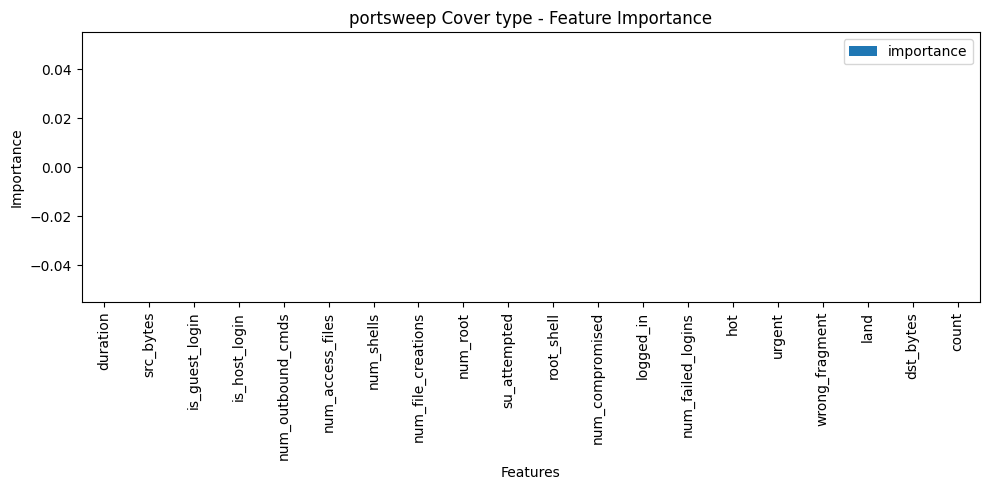

-----------------------------------------------------------------------------------------------




processtable importance list:
processtable 
                     importance
Features                      
dst_bytes             0.004367
src_bytes             0.003517
logged_in             0.001045
num_compromised       0.000016
num_access_files      0.000008
duration              0.000000
num_root              0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_shells            0.000000
num_file_creations    0.000000
root_shell            0.000000
su_attempted          0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
count                 0.000000 



processtable=["dst_bytes","src_bytes","logged_in","num_compromised","num_access_files"]


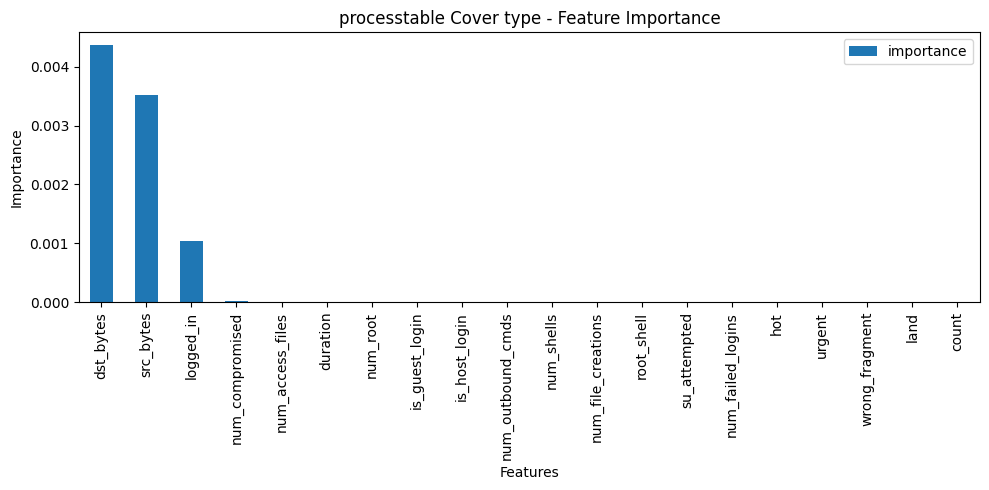

-----------------------------------------------------------------------------------------------




phf importance list:
phf 
                     importance
Features                      
num_access_files      0.190173
hot                   0.151271
root_shell            0.123034
src_bytes             0.065873
count                 0.000959
urgent                0.000000
wrong_fragment        0.000000
num_failed_logins     0.000000
logged_in             0.000000
num_compromised       0.000000
land                  0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
dst_bytes             0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
duration              0.000000 



phf=["num_access_files","hot","root_shell","src_bytes","count"]


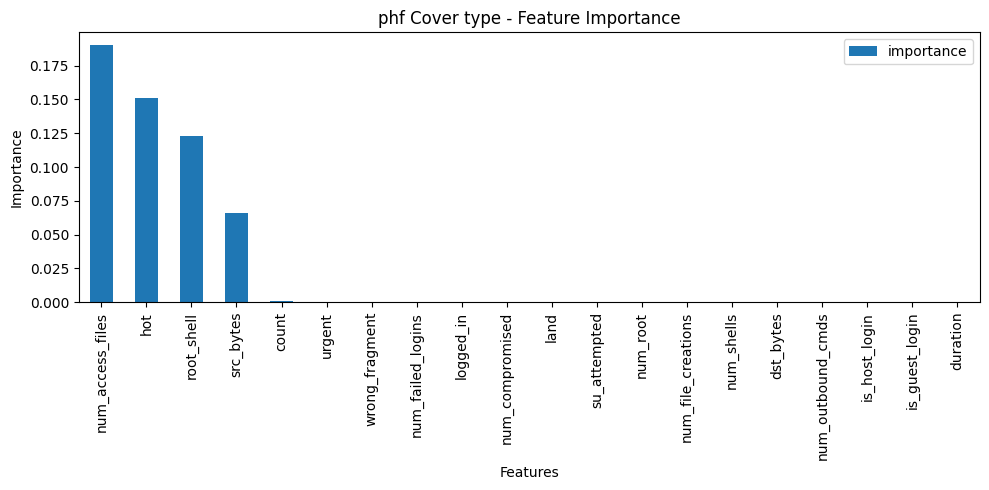

-----------------------------------------------------------------------------------------------




loadmodule importance list:
loadmodule 
                     importance
Features                      
duration              0.149533
num_compromised       0.126168
hot                   0.121495
num_shells            0.088785
num_file_creations    0.079439
root_shell            0.079439
urgent                0.000000
num_failed_logins     0.000000
logged_in             0.000000
wrong_fragment        0.000000
src_bytes             0.000000
su_attempted          0.000000
num_root              0.000000
land                  0.000000
dst_bytes             0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
count                 0.000000 



loadmodule=["duration","num_compromised","hot","num_shells","num_file_creations"]


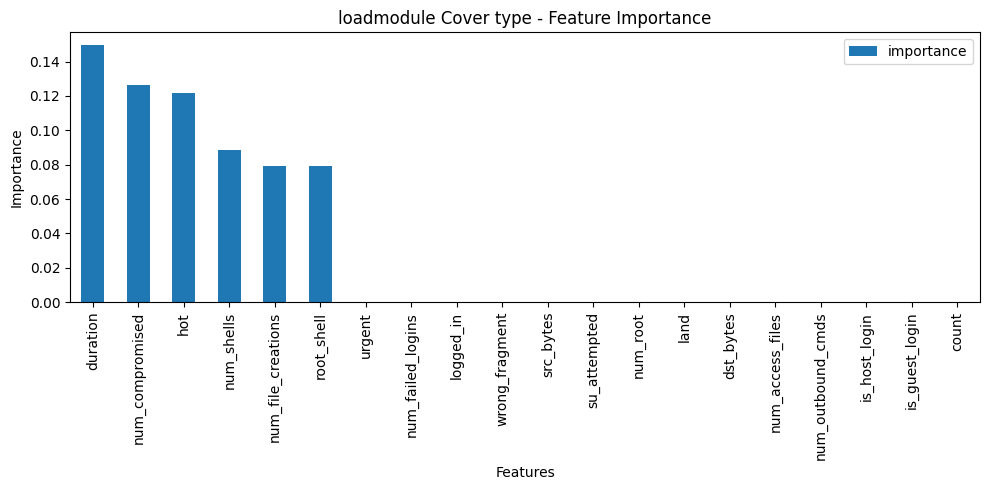

-----------------------------------------------------------------------------------------------




httptunnel importance list:
httptunnel 
                     importance
Features                      
duration              0.013805
src_bytes             0.004099
su_attempted          0.000409
num_compromised       0.000376
num_shells            0.000348
root_shell            0.000346
num_root              0.000299
count                 0.000198
hot                   0.000113
logged_in             0.000030
dst_bytes             0.000025
num_failed_logins     0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
num_file_creations    0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000 



httptunnel=["duration","src_bytes","su_attempted","num_compromised","num_shells"]


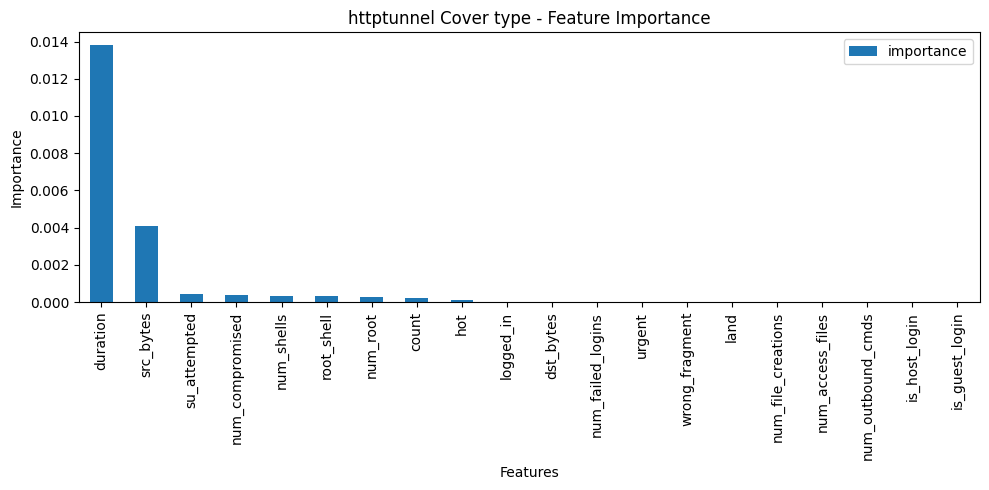

-----------------------------------------------------------------------------------------------




mscan importance list:
mscan 
                     importance
Features                      
src_bytes             0.933252
dst_bytes             0.000424
hot                   0.000362
count                 0.000088
num_root              0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
duration              0.000000
su_attempted          0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
root_shell            0.000000 



mscan=["src_bytes","dst_bytes","hot","count","num_root"]


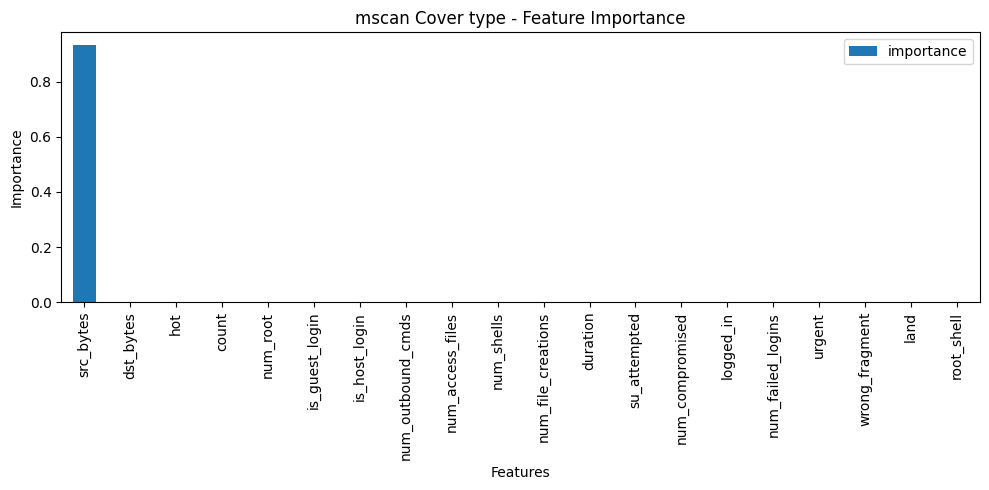

-----------------------------------------------------------------------------------------------




buffer_overflow importance list:
buffer_overflow 
                     importance
Features                      
duration              0.094422
dst_bytes             0.062391
is_guest_login        0.016773
num_compromised       0.012231
num_file_creations    0.005613
src_bytes             0.004511
hot                   0.000786
num_root              0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
root_shell            0.000000
su_attempted          0.000000
logged_in             0.000000
num_failed_logins     0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
count                 0.000000 



buffer_overflow=["duration","dst_bytes","is_guest_login","num_compromised","num_file_creations"]


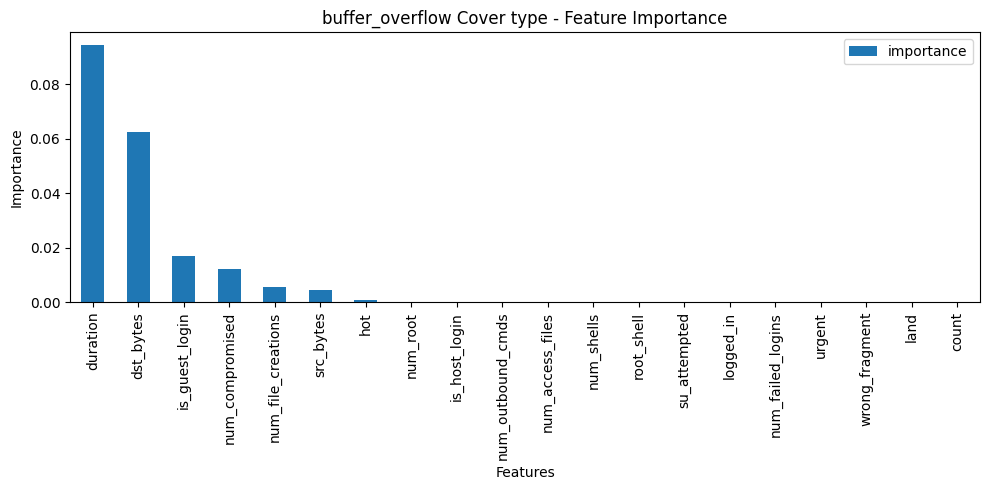

-----------------------------------------------------------------------------------------------




sendmail importance list:
sendmail 
                     importance
Features                      
src_bytes             0.009765
duration              0.008349
root_shell            0.007114
num_root              0.006995
num_access_files      0.004639
dst_bytes             0.001140
logged_in             0.000219
land                  0.000000
num_file_creations    0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_shells            0.000000
su_attempted          0.000000
wrong_fragment        0.000000
num_compromised       0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
count                 0.000000 



sendmail=["src_bytes","duration","root_shell","num_root","num_access_files"]


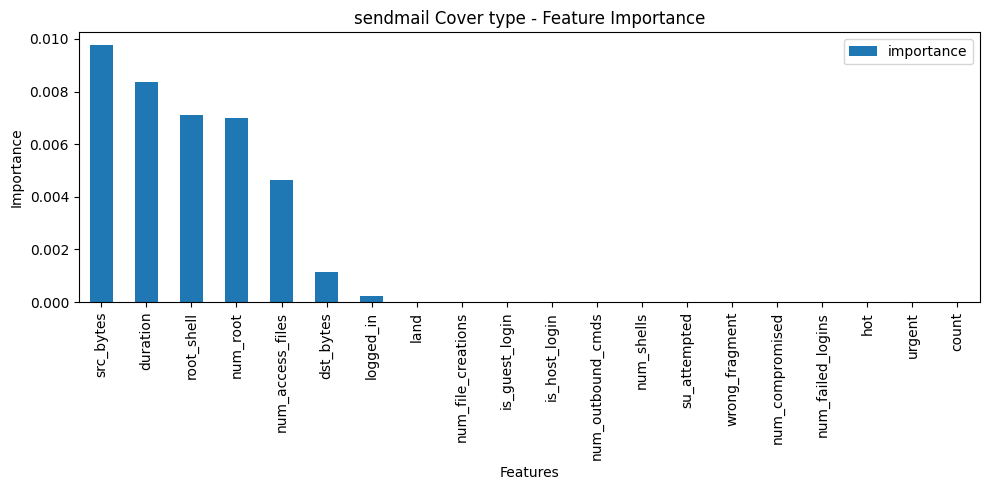

-----------------------------------------------------------------------------------------------




imap importance list:
imap 
                     importance
Features                      
duration              0.156627
src_bytes             0.012048
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
num_root              0.000000
su_attempted          0.000000
root_shell            0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
dst_bytes             0.000000
count                 0.000000 



imap=["duration","src_bytes","is_guest_login","is_host_login","num_outbound_cmds"]


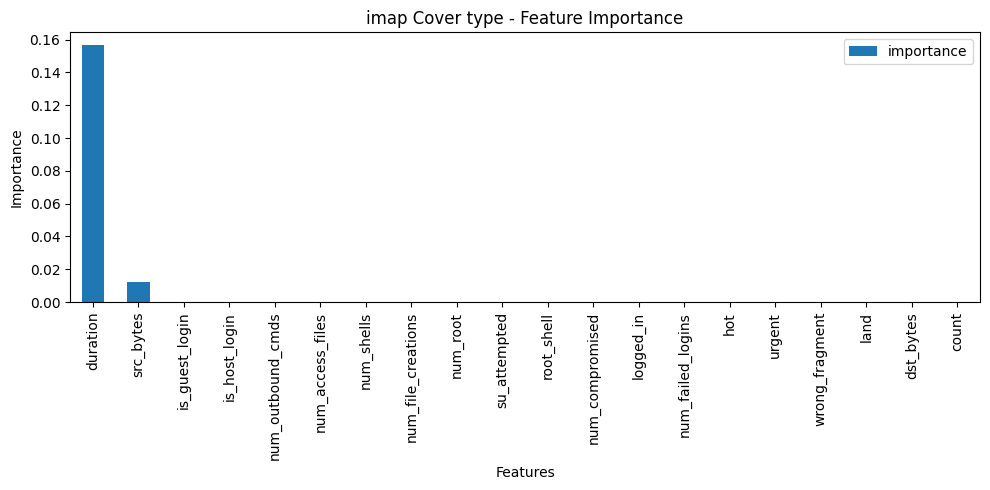

-----------------------------------------------------------------------------------------------




back importance list:
back 
                     importance
Features                      
src_bytes             0.987062
hot                   0.007946
logged_in             0.000733
dst_bytes             0.000177
num_compromised       0.000051
duration              0.000019
root_shell            0.000017
num_failed_logins     0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
count                 0.000000 



back=["src_bytes","hot","logged_in","dst_bytes","num_compromised"]


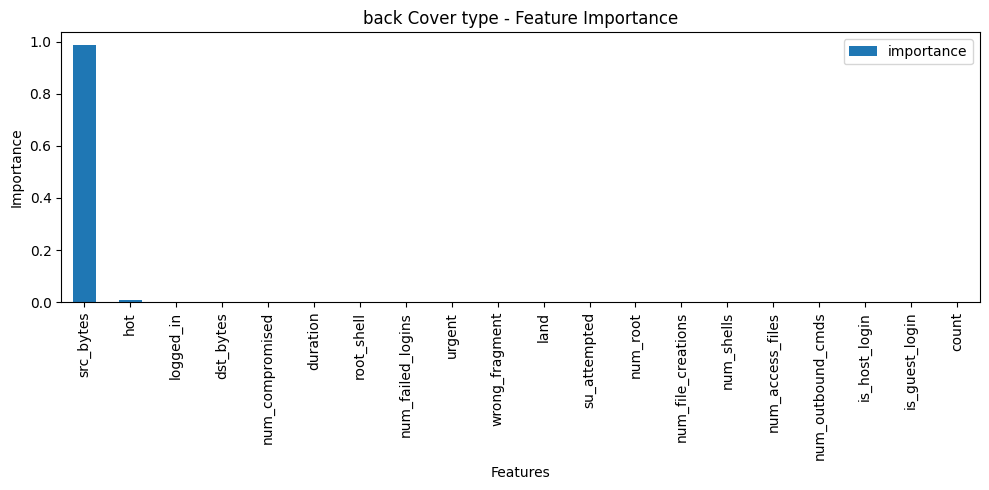

-----------------------------------------------------------------------------------------------




smurf importance list:
smurf 
                     importance
Features                      
count                 0.001844
src_bytes             0.000042
wrong_fragment        0.000035
su_attempted          0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
num_root              0.000000
duration              0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
land                  0.000000
dst_bytes             0.000000
root_shell            0.000000 



smurf=["count","src_bytes","wrong_fragment","su_attempted","is_guest_login"]


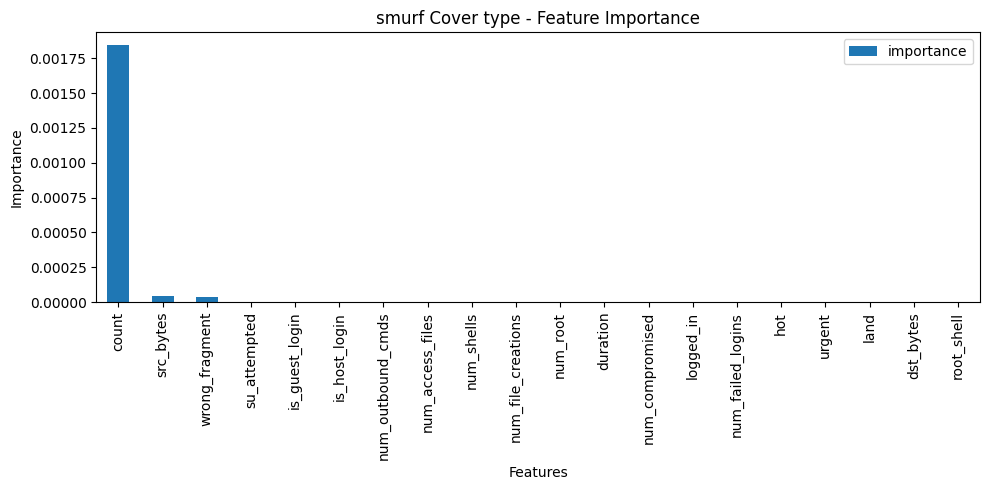

-----------------------------------------------------------------------------------------------




ipsweep importance list:
ipsweep 
                     importance
Features                      
src_bytes             0.006362
count                 0.001187
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
num_root              0.000000
su_attempted          0.000000
duration              0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
dst_bytes             0.000000
root_shell            0.000000 



ipsweep=["src_bytes","count","is_guest_login","is_host_login","num_outbound_cmds"]


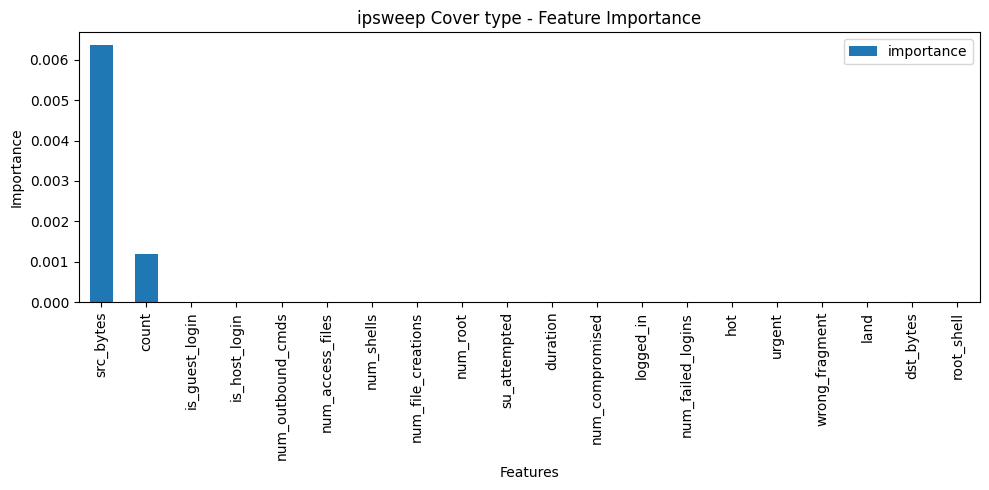

-----------------------------------------------------------------------------------------------




udpstorm importance list:
udpstorm 
                     importance
Features                      
src_bytes             0.433628
dst_bytes             0.008850
duration              0.000000
su_attempted          0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
num_root              0.000000
root_shell            0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
count                 0.000000 



udpstorm=["src_bytes","dst_bytes","duration","su_attempted","is_guest_login"]


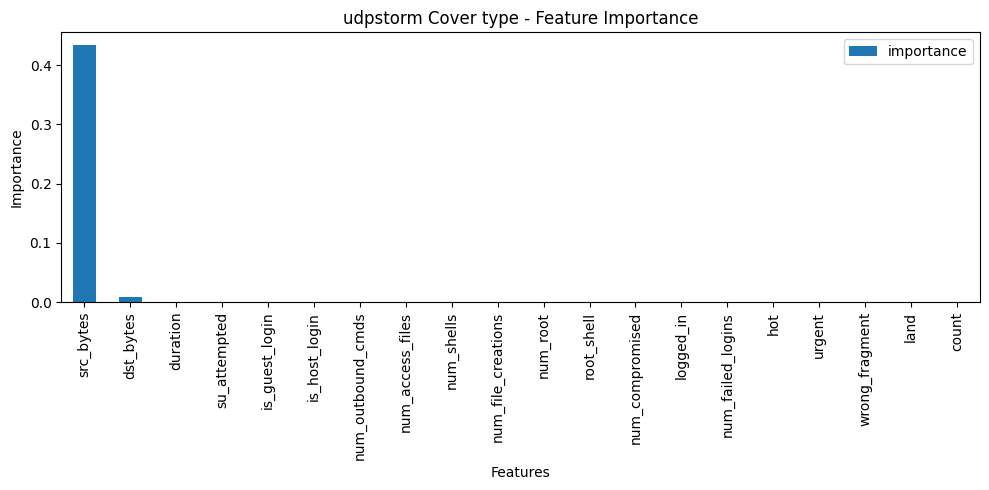

-----------------------------------------------------------------------------------------------




ps importance list:
ps 
                     importance
Features                      
duration              0.220987
hot                   0.050512
dst_bytes             0.024609
num_file_creations    0.019240
src_bytes             0.011792
num_compromised       0.002671
count                 0.001188
num_root              0.001176
num_access_files      0.000935
num_shells            0.000929
root_shell            0.000576
num_failed_logins     0.000000
logged_in             0.000000
urgent                0.000000
wrong_fragment        0.000000
su_attempted          0.000000
land                  0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000 



ps=["duration","hot","dst_bytes","num_file_creations","src_bytes"]


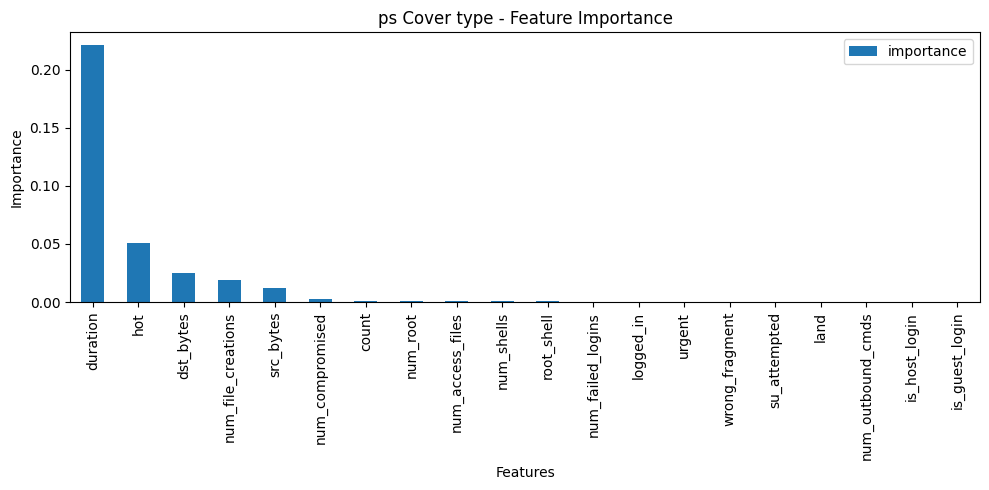

-----------------------------------------------------------------------------------------------




neptune importance list:
neptune 
                     importance
Features                      
count                 0.004325
src_bytes             0.000132
logged_in             0.000095
dst_bytes             0.000054
duration              0.000009
urgent                0.000000
hot                   0.000000
num_failed_logins     0.000000
wrong_fragment        0.000000
num_compromised       0.000000
land                  0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
root_shell            0.000000 



neptune=["count","src_bytes","logged_in","dst_bytes","duration"]


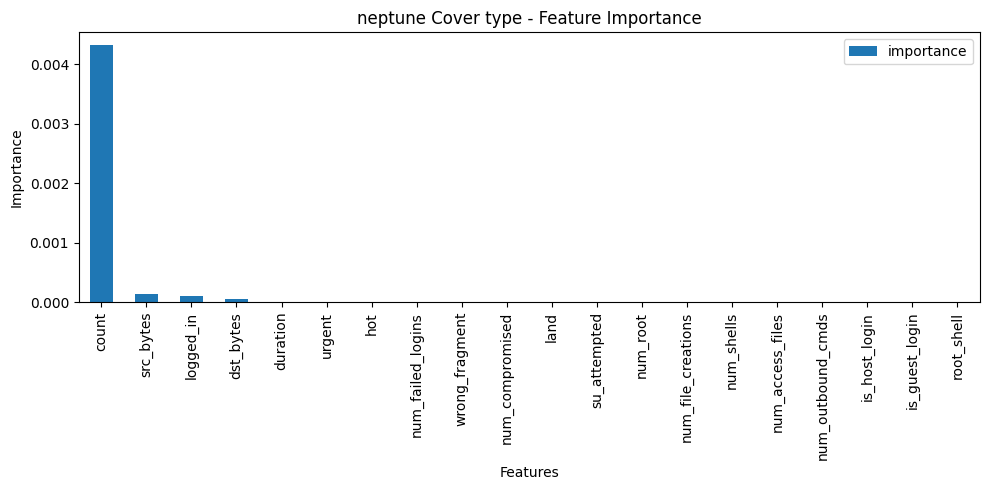

-----------------------------------------------------------------------------------------------




teardrop importance list:
teardrop 
                     importance
Features                      
wrong_fragment           0.808
src_bytes                0.184
duration                 0.000
su_attempted             0.000
is_guest_login           0.000
is_host_login            0.000
num_outbound_cmds        0.000
num_access_files         0.000
num_shells               0.000
num_file_creations       0.000
num_root                 0.000
root_shell               0.000
num_compromised          0.000
logged_in                0.000
num_failed_logins        0.000
hot                      0.000
urgent                   0.000
land                     0.000
dst_bytes                0.000
count                    0.000 



teardrop=["wrong_fragment","src_bytes","duration","su_attempted","is_guest_login"]


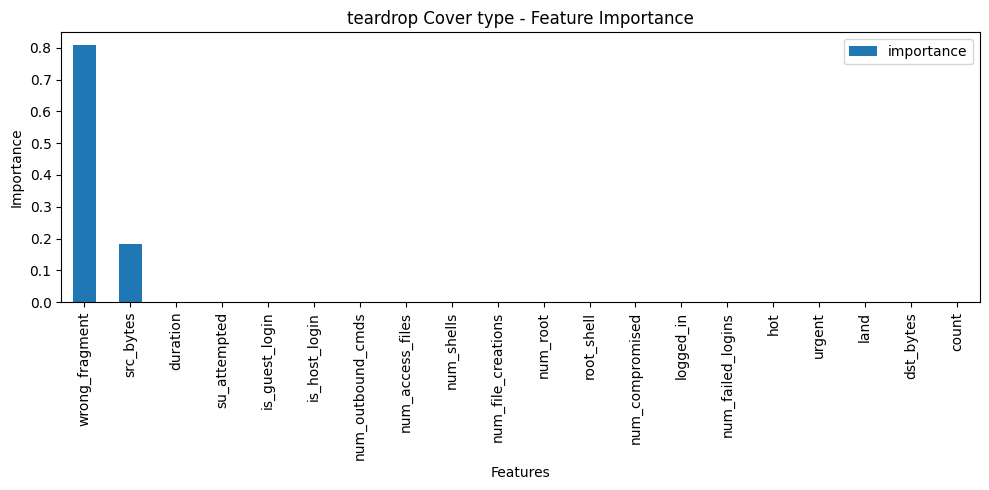

-----------------------------------------------------------------------------------------------




pod importance list:
pod 
                     importance
Features                      
src_bytes             0.167768
wrong_fragment        0.050005
dst_bytes             0.000541
count                 0.000140
num_root              0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
duration              0.000000
su_attempted          0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
land                  0.000000
root_shell            0.000000 



pod=["src_bytes","wrong_fragment","dst_bytes","count","num_root"]


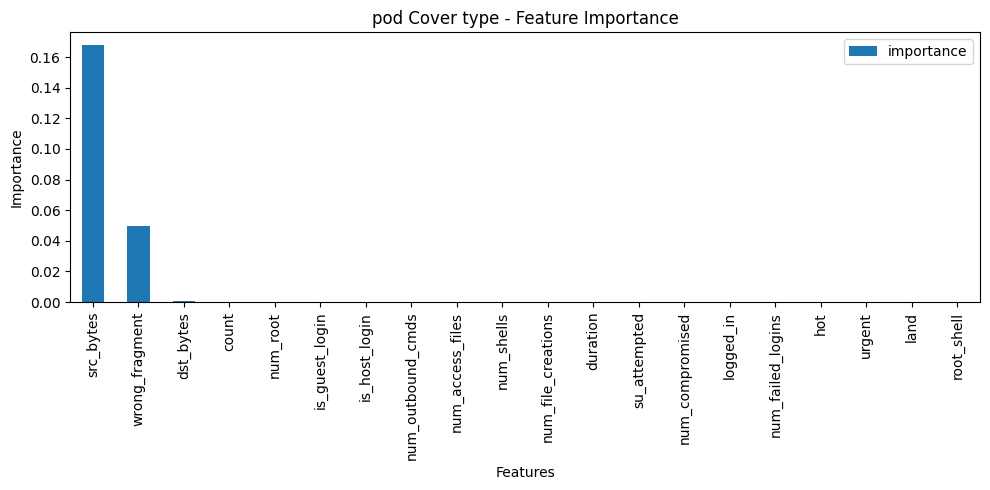

-----------------------------------------------------------------------------------------------




warezmaster importance list:
warezmaster 
                     importance
Features                      
src_bytes             0.032699
dst_bytes             0.020006
duration              0.005632
hot                   0.001384
is_guest_login        0.000687
count                 0.000664
logged_in             0.000106
wrong_fragment        0.000050
is_host_login         0.000019
urgent                0.000000
num_failed_logins     0.000000
num_compromised       0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
land                  0.000000
root_shell            0.000000 



warezmaster=["src_bytes","dst_bytes","duration","hot","is_guest_login"]


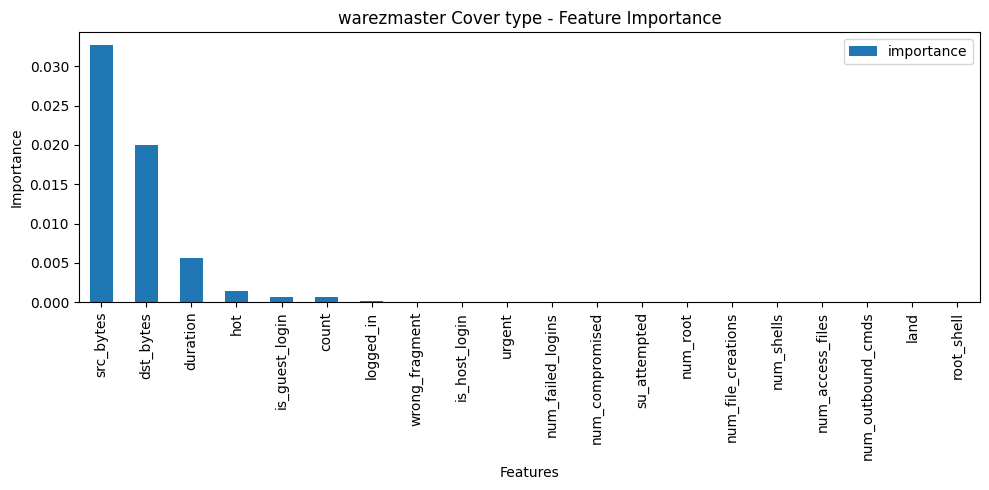

-----------------------------------------------------------------------------------------------




named importance list:
named 
                     importance
Features                      
src_bytes             0.039948
count                 0.020565
duration              0.015286
dst_bytes             0.002099
is_host_login         0.000322
land                  0.000000
num_root              0.000000
is_guest_login        0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
su_attempted          0.000000
wrong_fragment        0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
root_shell            0.000000 



named=["src_bytes","count","duration","dst_bytes","is_host_login"]


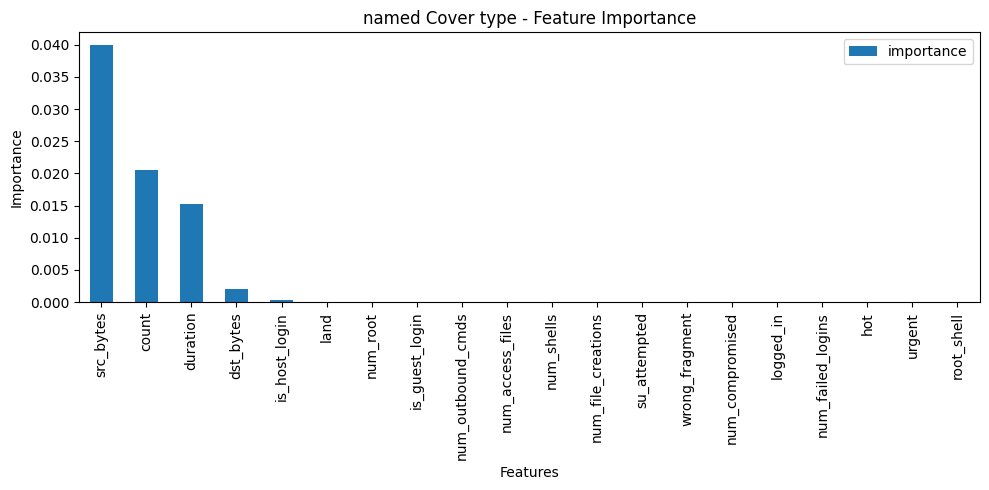

-----------------------------------------------------------------------------------------------




xterm importance list:
xterm 
                     importance
Features                      
duration              0.092024
hot                   0.081501
src_bytes             0.060692
urgent                0.006308
num_access_files      0.005087
num_compromised       0.004766
root_shell            0.004188
count                 0.003023
dst_bytes             0.001251
num_file_creations    0.001075
num_shells            0.000937
num_root              0.000632
logged_in             0.000434
is_host_login         0.000380
num_failed_logins     0.000000
wrong_fragment        0.000000
land                  0.000000
su_attempted          0.000000
num_outbound_cmds     0.000000
is_guest_login        0.000000 



xterm=["duration","hot","src_bytes","urgent","num_access_files"]


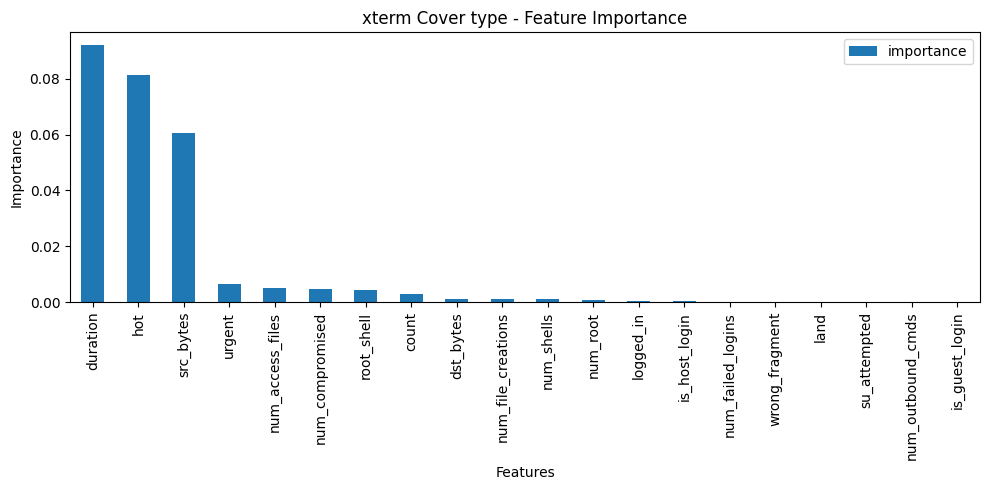

-----------------------------------------------------------------------------------------------




snmpguess importance list:
snmpguess 
                     importance
Features                      
src_bytes             0.816997
count                 0.003817
dst_bytes             0.000831
su_attempted          0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
num_root              0.000000
duration              0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
root_shell            0.000000 



snmpguess=["src_bytes","count","dst_bytes","su_attempted","is_guest_login"]


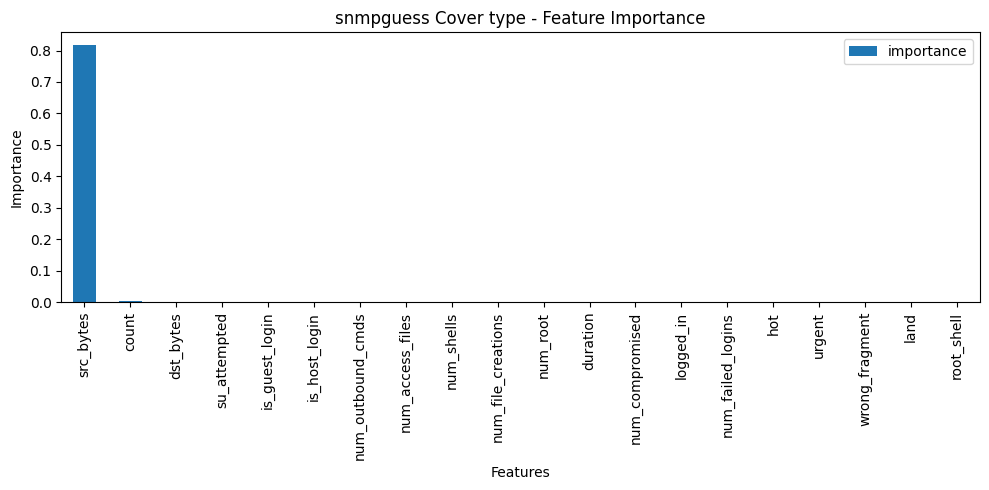

-----------------------------------------------------------------------------------------------




xsnoop importance list:
xsnoop 
                     importance
Features                      
duration              0.229410
dst_bytes             0.023116
hot                   0.022610
num_root              0.021403
root_shell            0.020325
is_host_login         0.011608
src_bytes             0.011439
count                 0.004432
num_shells            0.004065
urgent                0.000000
wrong_fragment        0.000000
num_failed_logins     0.000000
logged_in             0.000000
num_compromised       0.000000
su_attempted          0.000000
land                  0.000000
num_file_creations    0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_guest_login        0.000000 



xsnoop=["duration","dst_bytes","hot","num_root","root_shell"]


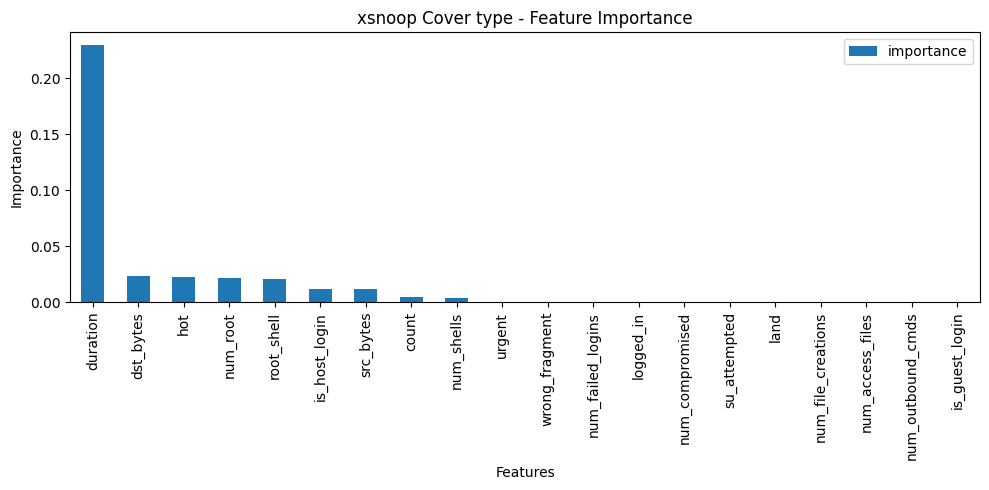

-----------------------------------------------------------------------------------------------




rootkit importance list:
rootkit 
                     importance
Features                      
duration              0.021671
src_bytes             0.006645
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
num_root              0.000000
su_attempted          0.000000
root_shell            0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
dst_bytes             0.000000
count                 0.000000 



rootkit=["duration","src_bytes","is_guest_login","is_host_login","num_outbound_cmds"]


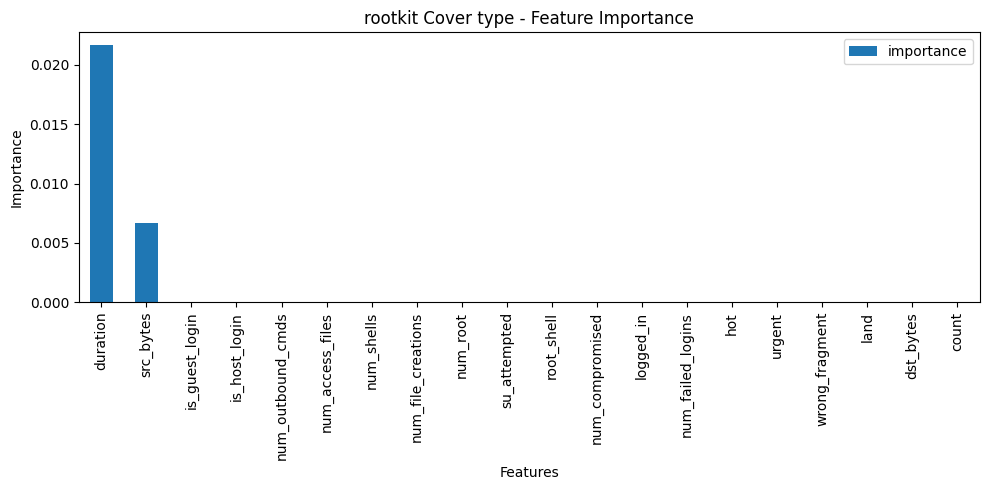

-----------------------------------------------------------------------------------------------




ftp_write importance list:
ftp_write 
                     importance
Features                      
src_bytes             0.113826
duration              0.071062
hot                   0.027381
urgent                0.024691
num_access_files      0.016461
dst_bytes             0.014845
num_file_creations    0.012346
is_guest_login        0.007140
num_root              0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_shells            0.000000
root_shell            0.000000
su_attempted          0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
wrong_fragment        0.000000
land                  0.000000
count                 0.000000 



ftp_write=["src_bytes","duration","hot","urgent","num_access_files"]


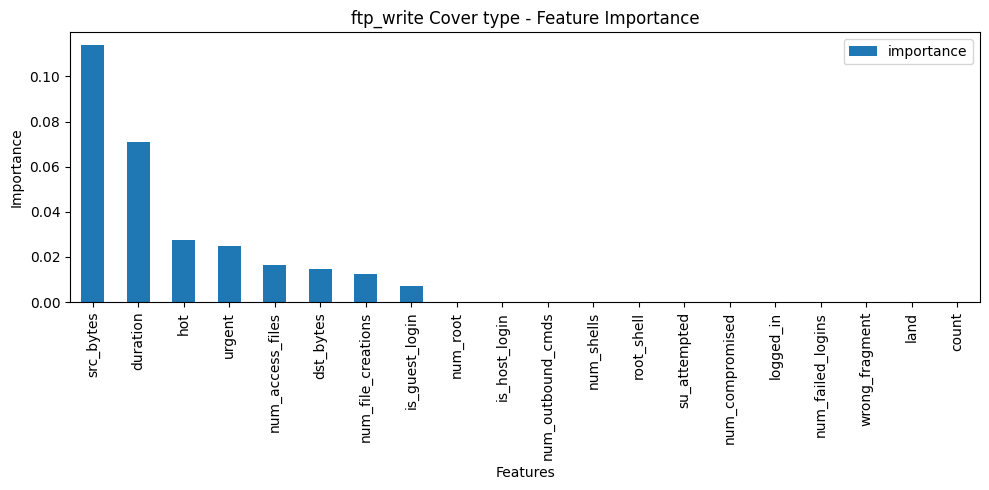

-----------------------------------------------------------------------------------------------




snmpgetattack importance list:
snmpgetattack 
                     importance
Features                      
dst_bytes             0.200899
count                 0.020424
duration              0.000382
src_bytes             0.000062
land                  0.000000
num_root              0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
su_attempted          0.000000
wrong_fragment        0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
root_shell            0.000000 



snmpgetattack=["dst_bytes","count","duration","src_bytes","land"]


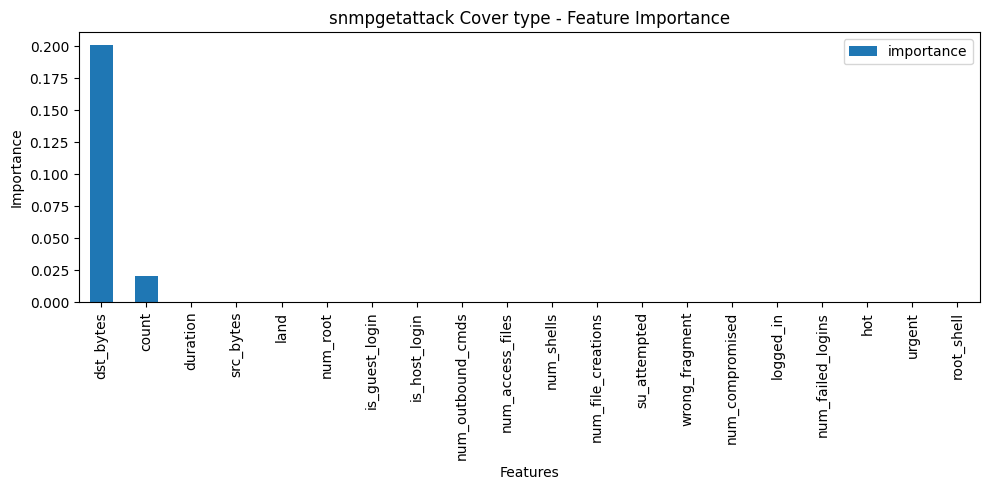

-----------------------------------------------------------------------------------------------




saint importance list:
saint 
                     importance
Features                      
src_bytes             0.946568
dst_bytes             0.028837
count                 0.001477
logged_in             0.000666
duration              0.000056
num_root              0.000013
urgent                0.000000
hot                   0.000000
num_failed_logins     0.000000
wrong_fragment        0.000000
num_compromised       0.000000
land                  0.000000
su_attempted          0.000000
num_file_creations    0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
root_shell            0.000000 



saint=["src_bytes","dst_bytes","count","logged_in","duration"]


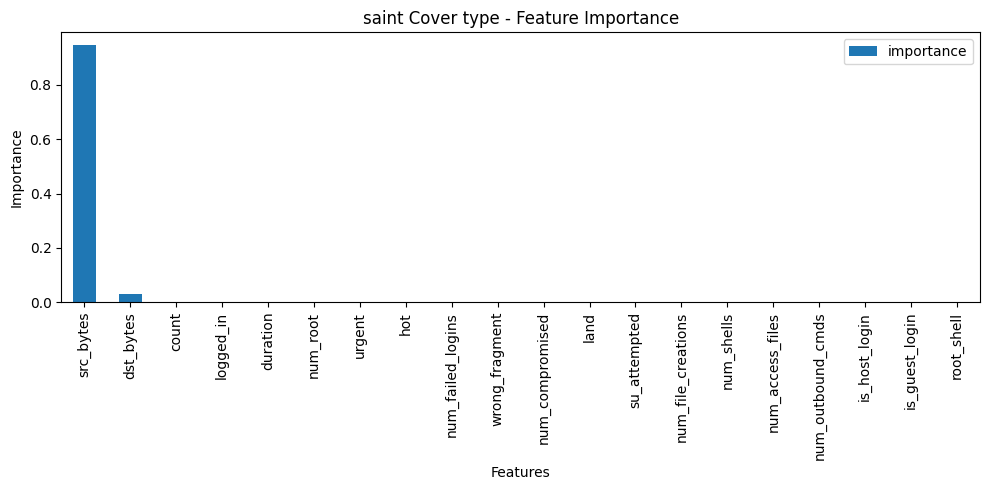

-----------------------------------------------------------------------------------------------




sqlattack importance list:
sqlattack 
                     importance
Features                      
num_access_files      0.119816
urgent                0.119816
num_root              0.115207
num_file_creations    0.092166
num_shells            0.087558
hot                   0.078341
root_shell            0.064516
src_bytes             0.027650
duration              0.018433
num_compromised       0.000000
logged_in             0.000000
su_attempted          0.000000
num_failed_logins     0.000000
wrong_fragment        0.000000
land                  0.000000
dst_bytes             0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
count                 0.000000 



sqlattack=["num_access_files","urgent","num_root","num_file_creations","num_shells"]


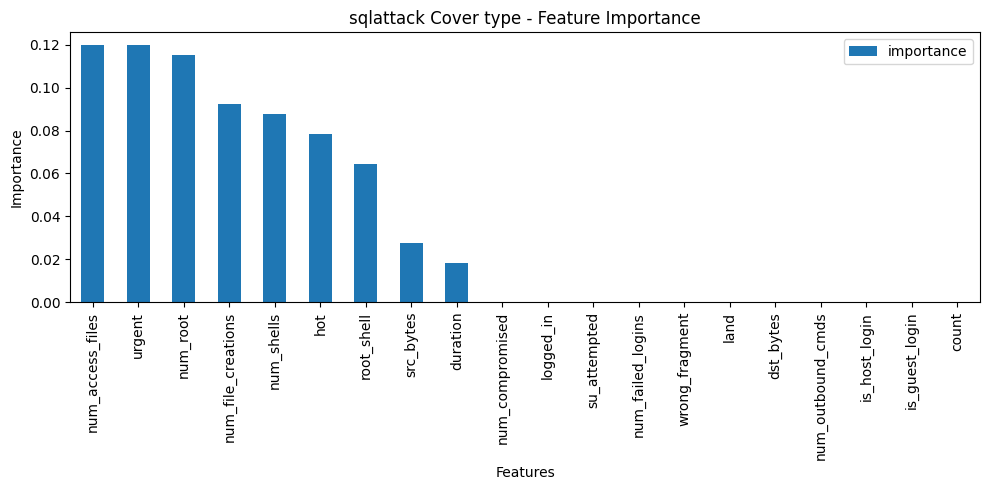

-----------------------------------------------------------------------------------------------




land importance list:
land 
                     importance
Features                      
land                     0.148
src_bytes                0.100
duration                 0.000
su_attempted             0.000
is_guest_login           0.000
is_host_login            0.000
num_outbound_cmds        0.000
num_access_files         0.000
num_shells               0.000
num_file_creations       0.000
num_root                 0.000
root_shell               0.000
num_compromised          0.000
logged_in                0.000
num_failed_logins        0.000
hot                      0.000
urgent                   0.000
wrong_fragment           0.000
dst_bytes                0.000
count                    0.000 



land=["land","src_bytes","duration","su_attempted","is_guest_login"]


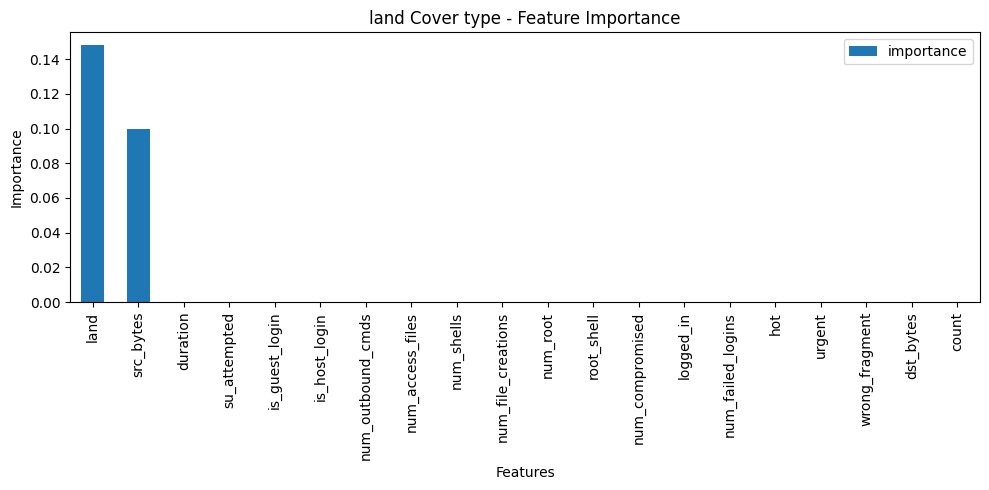

-----------------------------------------------------------------------------------------------




perl importance list:
perl 
                     importance
Features                      
duration              0.205479
num_shells            0.150685
num_file_creations    0.127854
num_root              0.031963
root_shell            0.022831
urgent                0.000000
hot                   0.000000
num_failed_logins     0.000000
logged_in             0.000000
num_compromised       0.000000
src_bytes             0.000000
su_attempted          0.000000
wrong_fragment        0.000000
land                  0.000000
dst_bytes             0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
count                 0.000000 



perl=["duration","num_shells","num_file_creations","num_root","root_shell"]


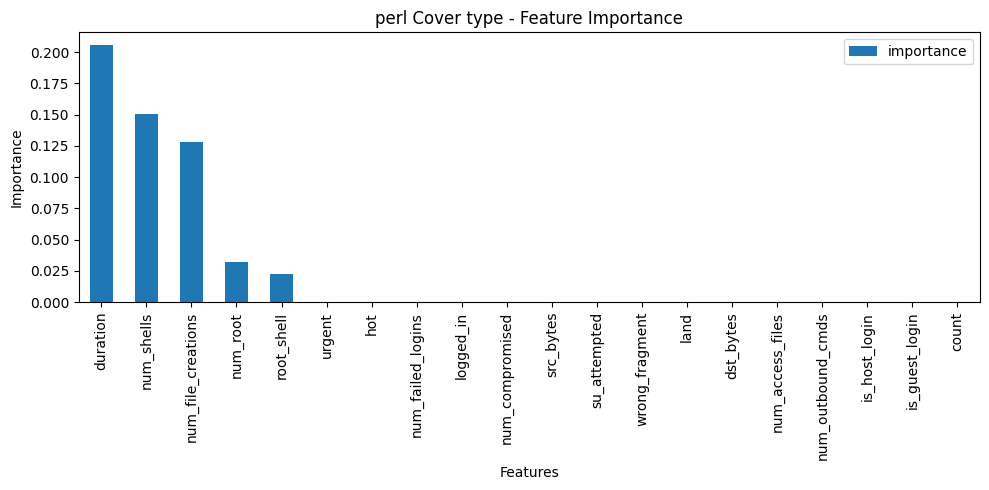

-----------------------------------------------------------------------------------------------




apache2 importance list:
apache2 
                     importance
Features                      
dst_bytes             0.001017
src_bytes             0.000737
duration              0.000200
su_attempted          0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
num_root              0.000000
root_shell            0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
count                 0.000000 



apache2=["dst_bytes","src_bytes","duration","su_attempted","is_guest_login"]


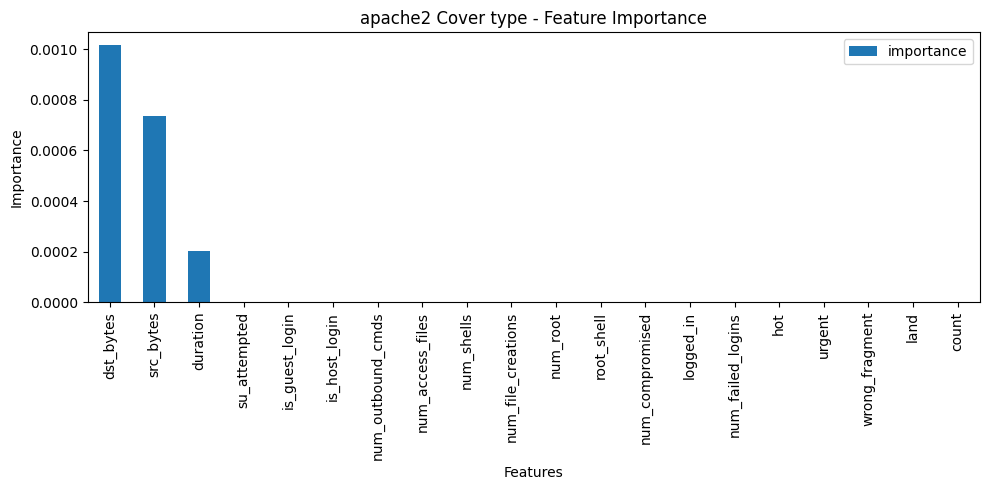

-----------------------------------------------------------------------------------------------




guess_passwd importance list:
guess_passwd 
                     importance
Features                      
num_failed_logins     0.224663
src_bytes             0.001388
dst_bytes             0.000666
duration              0.000195
logged_in             0.000002
hot                   0.000001
num_file_creations    0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
root_shell            0.000000
num_root              0.000000
su_attempted          0.000000
num_compromised       0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
count                 0.000000 



guess_passwd=["num_failed_logins","src_bytes","dst_bytes","duration","logged_in"]


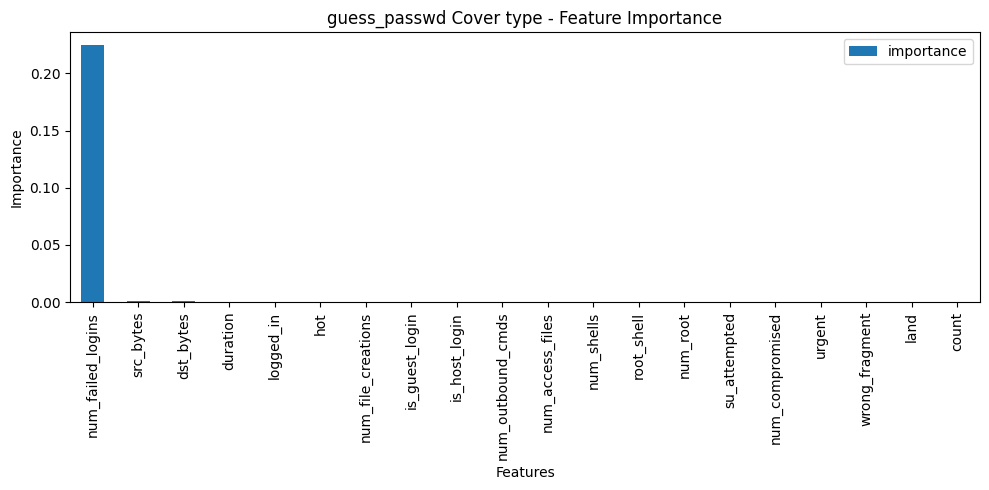

-----------------------------------------------------------------------------------------------




xlock importance list:
xlock 
                     importance
Features                      
duration                 0.464
dst_bytes                0.008
src_bytes                0.008
su_attempted             0.000
is_guest_login           0.000
is_host_login            0.000
num_outbound_cmds        0.000
num_access_files         0.000
num_shells               0.000
num_file_creations       0.000
num_root                 0.000
root_shell               0.000
num_compromised          0.000
logged_in                0.000
num_failed_logins        0.000
hot                      0.000
urgent                   0.000
wrong_fragment           0.000
land                     0.000
count                    0.000 



xlock=["duration","dst_bytes","src_bytes","su_attempted","is_guest_login"]


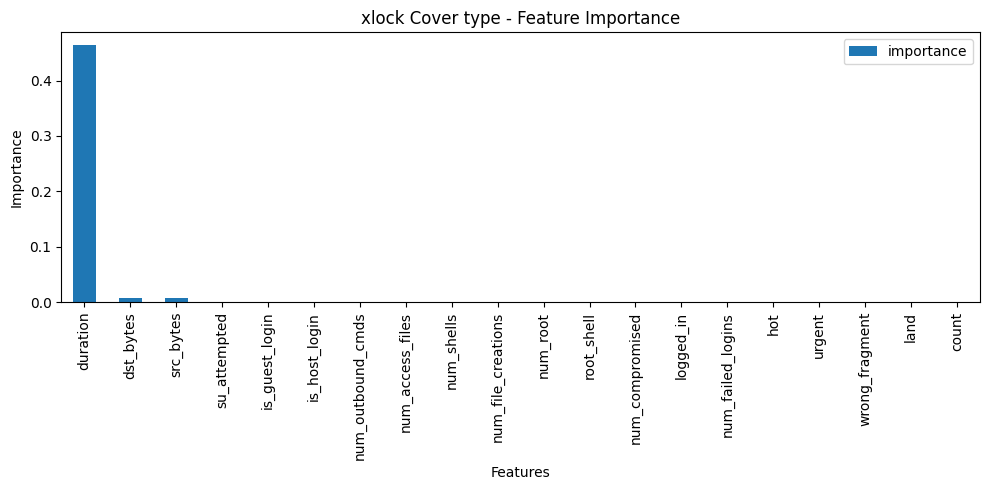

-----------------------------------------------------------------------------------------------




nmap importance list:
nmap 
                     importance
Features                      
src_bytes                0.032
duration                 0.000
is_guest_login           0.000
is_host_login            0.000
num_outbound_cmds        0.000
num_access_files         0.000
num_shells               0.000
num_file_creations       0.000
num_root                 0.000
su_attempted             0.000
root_shell               0.000
num_compromised          0.000
logged_in                0.000
num_failed_logins        0.000
hot                      0.000
urgent                   0.000
wrong_fragment           0.000
land                     0.000
dst_bytes                0.000
count                    0.000 



nmap=["src_bytes","duration","is_guest_login","is_host_login","num_outbound_cmds"]


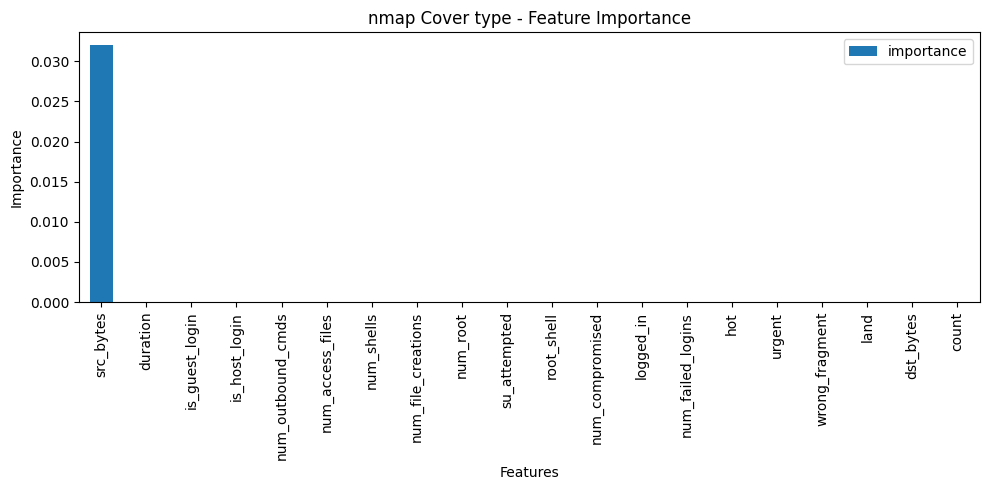

-----------------------------------------------------------------------------------------------




worm importance list:
worm 
                     importance
Features                      
src_bytes             0.159624
duration              0.098592
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
num_root              0.000000
su_attempted          0.000000
root_shell            0.000000
num_compromised       0.000000
logged_in             0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
dst_bytes             0.000000
count                 0.000000 



worm=["src_bytes","duration","is_guest_login","is_host_login","num_outbound_cmds"]


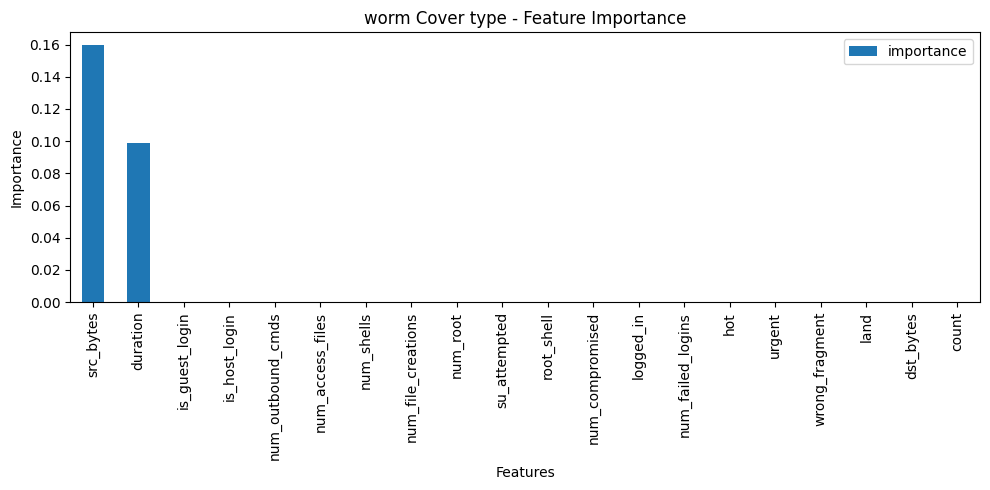

-----------------------------------------------------------------------------------------------




multihop importance list:
multihop 
                     importance
Features                      
duration                   0.0
src_bytes                  0.0
is_guest_login             0.0
is_host_login              0.0
num_outbound_cmds          0.0
num_access_files           0.0
num_shells                 0.0
num_file_creations         0.0
num_root                   0.0
su_attempted               0.0
root_shell                 0.0
num_compromised            0.0
logged_in                  0.0
num_failed_logins          0.0
hot                        0.0
urgent                     0.0
wrong_fragment             0.0
land                       0.0
dst_bytes                  0.0
count                      0.0 



multihop=["duration","src_bytes","is_guest_login","is_host_login","num_outbound_cmds"]


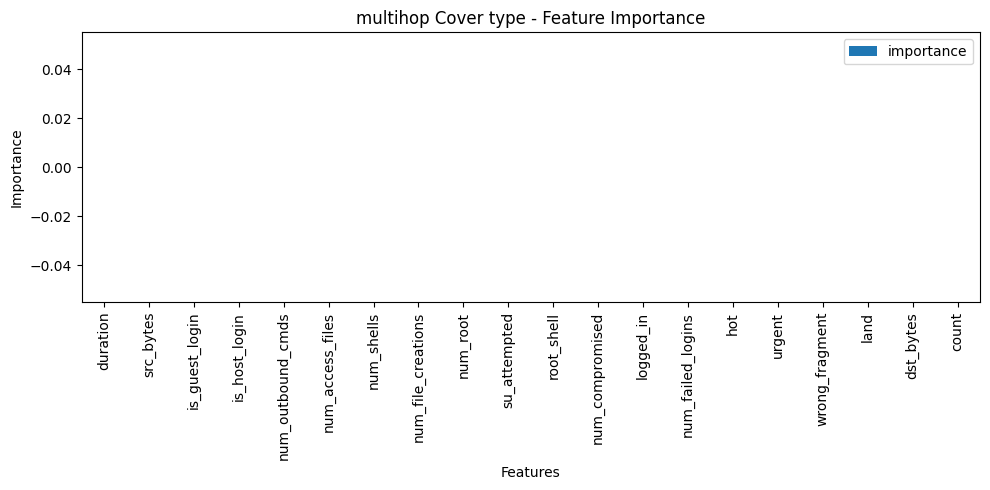

-----------------------------------------------------------------------------------------------




satan importance list:
satan 
                     importance
Features                      
src_bytes             0.000945
count                 0.000293
dst_bytes             0.000051
duration              0.000030
logged_in             0.000014
hot                   0.000006
wrong_fragment        0.000000
urgent                0.000000
num_failed_logins     0.000000
num_compromised       0.000000
land                  0.000000
su_attempted          0.000000
num_root              0.000000
num_file_creations    0.000000
num_shells            0.000000
num_access_files      0.000000
num_outbound_cmds     0.000000
is_host_login         0.000000
is_guest_login        0.000000
root_shell            0.000000 



satan=["src_bytes","count","dst_bytes","duration","logged_in"]


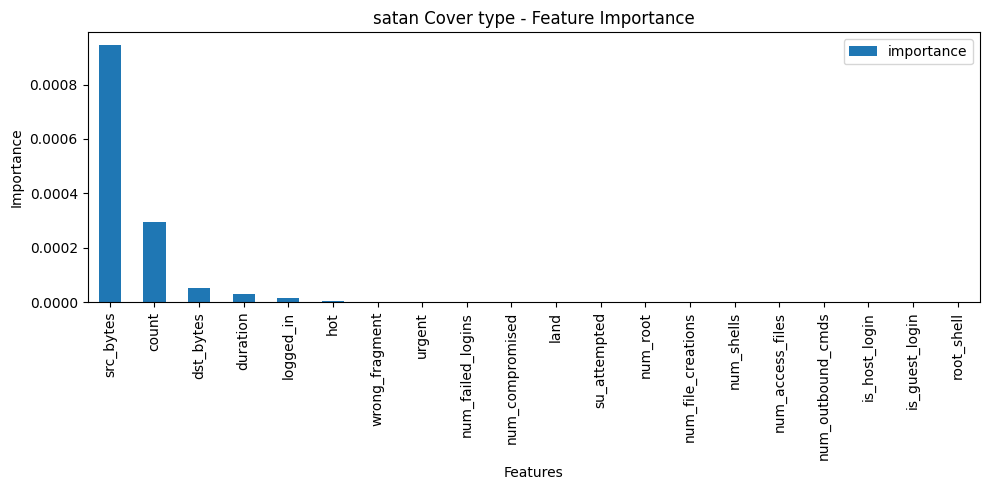

-----------------------------------------------------------------------------------------------




mailbomb importance list:
mailbomb 
                     importance
Features                      
src_bytes             0.049275
duration              0.000049
dst_bytes             0.000025
logged_in             0.000011
num_root              0.000000
is_guest_login        0.000000
is_host_login         0.000000
num_outbound_cmds     0.000000
num_access_files      0.000000
num_shells            0.000000
num_file_creations    0.000000
root_shell            0.000000
su_attempted          0.000000
num_compromised       0.000000
num_failed_logins     0.000000
hot                   0.000000
urgent                0.000000
wrong_fragment        0.000000
land                  0.000000
count                 0.000000 



mailbomb=["src_bytes","duration","dst_bytes","logged_in","num_root"]


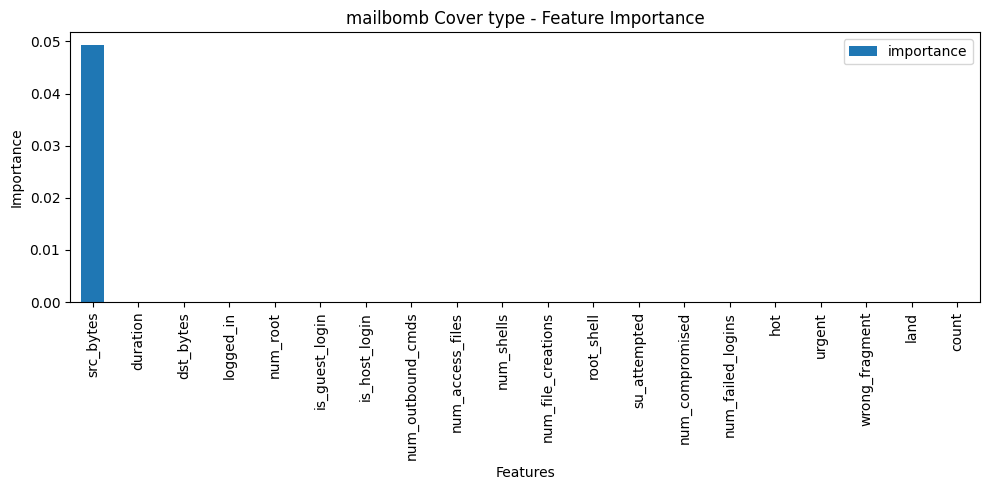

-----------------------------------------------------------------------------------------------




feature_importances: {'portsweep': ['duration', 'src_bytes', 'is_guest_login', 'is_host_login', 'num_outbound_cmds'], 'processtable': ['dst_bytes', 'src_bytes', 'logged_in', 'num_compromised', 'num_access_files'], 'phf': ['num_access_files', 'hot', 'root_shell', 'src_bytes', 'count'], 'loadmodule': ['duration', 'num_compromised', 'hot', 'num_shells', 'num_file_creations'], 'httptunnel': ['duration', 'src_bytes', 'su_attempted', 'num_compromised', 'num_shells'], 'mscan': ['src_bytes', 'dst_bytes', 'hot', 'count', 'num_root'], 'buffer_overflow': ['duration', 'dst_bytes', 'is_guest_login', 'num_compromised', 'num_file_creations'], 'sendmail': ['src_bytes', 'duration', 'root_shell', 'num_root', 'num_access_files'], 'imap': ['duration', 'src_bytes', 'is_guest_login', 'is_host_login', 'num_outbound_cmds'], 'back': ['src_bytes', 'hot', 'logged_in', 'dst_bytes', 'num_compromised'], 'smurf': ['co

In [82]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)
print('csv_files',csv_files)

feature_importances = {}
SVMs = {}

process_csv_with_args = partial(
        common.process_csv, 
        main_labels=main_labels, 
        target_column=TARGET_COLUMN, 
        normal_target=NORMAL_TARGET, 
        numerical_columns=NUMERICAL_COLUMNS, 
        output_folder=OUTPUT_FOLDER,
        scaler=scaler 
    )

with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_csv_with_args, csv_files))

# Collect results from the futures
for label, important_features, svm, impor_bars in results:
    feature_importances[label] = important_features
    SVMs[label] = svm

    # Show feature importance
    common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances:', feature_importances)
print("Total operation time: =", time.time() - seconds, "seconds")

In [83]:
seconds = time.time()

# Step 1: Train KNN to classify
knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train_scaled_df, y_train_df)
knn.fit(X_train_df, y_train_df)

# Step 2: Predict classes for the test set
X_test_df = X_test_df[:TEST_COUNT]
X_test_scaled_df = X_test_scaled_df[:TEST_COUNT]
y_test_df = y_test_df[:TEST_COUNT]

# knn_predictions = knn.predict(X_test_scaled)
knn_predictions = knn.predict(X_test_df)
print('knn_predictions', knn_predictions)

print("Total operation time: = ",time.time()- seconds ,"seconds")

knn_predictions [27 14 27 16 27 16 16 14 16 27 27 27 14 27 27 16 27 14 16 14 27 14 16 14
 14 27 14 27 16 27 14 27 14 27 27 27 16  4 16 16 27 27 14 27 27 27 27 27
 27 33 27 27 14  4 14 27 27 10 27 27 27 27 14  1 14 16 16 16 16 16 27 14
 16 27 27 16 27 14 27 14 27 29 16 27 16 14 27 27 14 16 16 14 27 27 27 14
 27 27 27 27 10 16 25 27 14 14 14 27 14 14 16 27 27 14 27 14 27  1 27 14
 16 27 16 27 14 33 27 27 27 27 16 16 16 10 28 27 16 27 14 14 27 14 16 14
 27 14 16 16 16 27 27 27 14 27 14 27 16 27 27 27 27 27 27 27 27 27 27 16
 16 16 27 27 14 16 27 27 14 27 27 14 27 16 16 27 14 27 27 27 16 16 11 27
 14 16 28 27 14 27 14 16 16 27 27 16 27 27 14 16 16 27  4 27 16 27 14 16
 27 27 14 16 27 27 27 27 27  4 16 14 16 16 16 14 14 27 27 27 27 16 27 27
 16 16 16 16 16 16 16 27 16 14 14 14 29 27 27 27 27 14 16  0 27 16 16 16
 27 16 27 27 14  4 16 27 27 27 27 16 27 16 27 27 14 27 27 27 27 27 27 16
 27 27 27 27 14 27 27 27 27 27 16 14 24 27 27 27 27 16 14 27 14 27  4 14
 16 27 14 16 27 27 28 11 16 27 14 1

-----KNN Evaluation-----
Confusion Matrix:
[[  1   0   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   3   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   6   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   4   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   2   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 104   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0 119   0   0   0   0   2   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   2   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 235   0   0   0]
 [  0   0   0   0   0   0   6   0   0   0   0   3   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0   4   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   4]]


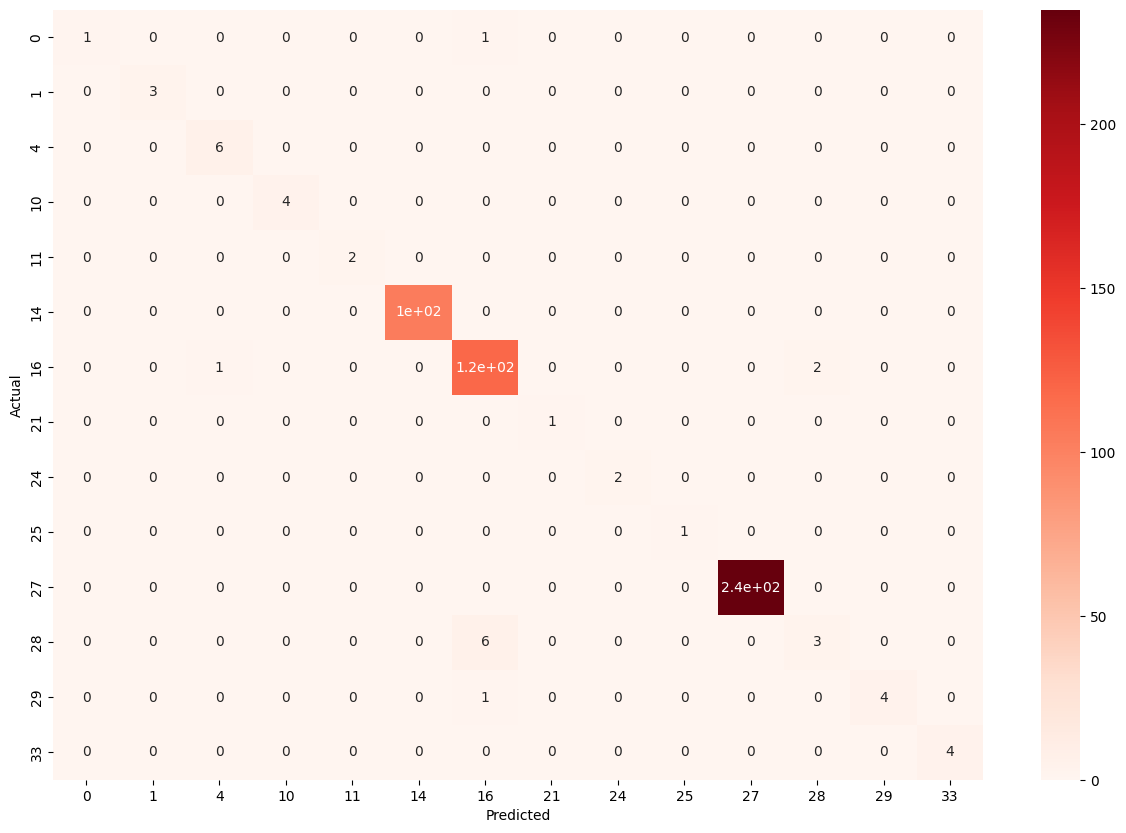


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      1.00      1.00         3
           4       0.86      1.00      0.92         6
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         2
          14       1.00      1.00      1.00       104
          16       0.94      0.98      0.96       122
          21       1.00      1.00      1.00         1
          24       1.00      1.00      1.00         2
          25       1.00      1.00      1.00         1
          27       1.00      1.00      1.00       235
          28       0.60      0.33      0.43         9
          29       1.00      0.80      0.89         5
          33       1.00      1.00      1.00         4

    accuracy                           0.98       500
   macro avg       0.96      0.90      0.92       500
weighted avg       0.98      0.98      0.98       500

A

In [84]:
common.evaluate(y_test_df, knn_predictions, heading='-----KNN Evaluation-----')

In [85]:
svm_predictions = []
seconds = time.time()

for i in range(len(X_test_scaled_df)):
    test_instance_df = X_test_scaled_df.iloc[i].to_frame().T
    if knn_predictions[i] == NORMAL_TARGET:
        svm_predictions.append((0, NORMAL_TARGET, y_test_df.iloc[i]))
        continue
    predicted_label = TARGET_DICT[knn_predictions[i]]
    # print('predicted_label', predicted_label)
    selected_features = feature_importances[predicted_label]
    # print('selected_features', selected_features)
    svm_model = SVMs[predicted_label]
    
    # Select features for the SVM
    test_instance_selected_df = test_instance_df[selected_features]
    svm_prediction = svm_model.predict(test_instance_selected_df)
    print('svm prediction: ', svm_prediction, 'knn prediction: ', INV_TARGET_DICT[predicted_label], 'actual value: ', y_test_df.iloc[i])
    svm_predictions.append((svm_prediction, INV_TARGET_DICT[predicted_label], y_test_df.iloc[i]))

print("Total operation time: = ",time.time()- seconds ,"seconds")

svm prediction:  [1] knn prediction:  27 actual value:  27
svm prediction:  [0] knn prediction:  14 actual value:  14
svm prediction:  [1] knn prediction:  27 actual value:  27
svm prediction:  [1] knn prediction:  27 actual value:  27
svm prediction:  [0] knn prediction:  14 actual value:  14
svm prediction:  [1] knn prediction:  27 actual value:  27
svm prediction:  [1] knn prediction:  27 actual value:  27
svm prediction:  [1] knn prediction:  27 actual value:  27
svm prediction:  [0] knn prediction:  14 actual value:  14
svm prediction:  [1] knn prediction:  27 actual value:  27
svm prediction:  [1] knn prediction:  27 actual value:  27
svm prediction:  [1] knn prediction:  27 actual value:  27
svm prediction:  [0] knn prediction:  14 actual value:  14
svm prediction:  [0] knn prediction:  14 actual value:  14
svm prediction:  [1] knn prediction:  27 actual value:  27
svm prediction:  [0] knn prediction:  14 actual value:  14
svm prediction:  [0] knn prediction:  14 actual value:  

anomaly_mask 500
[27, 14, 27, 16, 27, 16, 16, 14, 16, 27, 27, 27, 14, 27, 27, 16, 27, 14, 16, 14, 27, 14, 16, 14, 14, 27, 14, 27, 16, 27, 14, 27, 14, 27, 27, 27, 16, 4, 16, 16, 27, 27, 14, 27, 27, 27, 27, 27, 27, 33, 27, 27, 14, 4, 14, 27, 27, 10, 27, 27, 27, 27, 14, 1, 14, 16, 16, 16, 16, 16, 27, 14, 16, 27, 27, 16, 27, 14, 27, 14, 27, 29, 16, 27, 16, 14, 27, 27, 14, 16, 16, 14, 27, 27, 27, 14, 27, 27, 27, 27, 10, 16, 25, 27, 14, 14, 14, 27, 14, 14, 16, 27, 27, 14, 27, 14, 27, 1, 27, 14, 16, 27, 16, 27, 14, 33, 27, 27, 27, 27, 16, 16, 16, 10, 28, 27, 16, 27, 14, 14, 27, 14, 16, 14, 27, 14, 16, 16, 16, 27, 27, 27, 14, 27, 14, 27, 16, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 16, 16, 16, 27, 27, 14, 16, 27, 27, 14, 27, 27, 14, 27, 16, 16, 27, 14, 27, 27, 27, 16, 16, 11, 27, 14, 16, 28, 27, 14, 27, 14, 16, 16, 27, 27, 16, 27, 27, 14, 16, 16, 27, 4, 27, 16, 27, 14, 16, 27, 27, 14, 16, 27, 27, 27, 27, 27, 4, 16, 14, 16, 16, 16, 14, 14, 27, 27, 27, 27, 16, 27, 27, 16, 16, 16, 16, 16, 16, 16, 

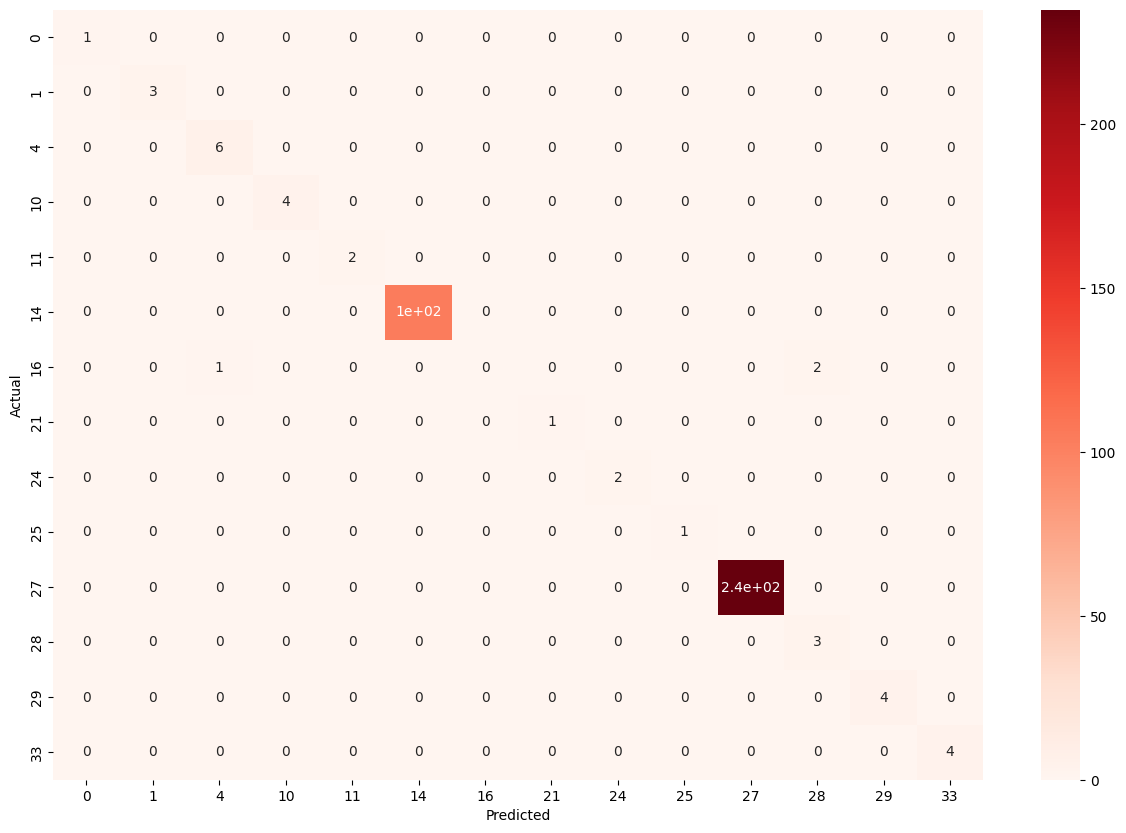


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3
           4       0.86      1.00      0.92         6
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         2
          14       1.00      1.00      1.00       104
          16       0.00      0.00      0.00         3
          21       1.00      1.00      1.00         1
          24       1.00      1.00      1.00         2
          25       1.00      1.00      1.00         1
          27       1.00      1.00      1.00       235
          28       0.60      1.00      0.75         3
          29       1.00      1.00      1.00         4
          33       1.00      1.00      1.00         4

    accuracy                           0.99       373
   macro avg       0.89      0.93      0.91       373
weighted avg       0.99      0.99      0.99       373

A

/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [86]:
# Now evaluate SVM predictions only for the anomalies detected by KNN
# Create a mask for test instances that KNN classified as anomalies
anomaly_mask = knn_predictions != NORMAL_TARGET  # Assuming normal_target is your normal class
print('anomaly_mask', len(anomaly_mask))

# Get true labels and predictions for anomalies
svm_predictions_actual = [t[1] for t in svm_predictions]
print(svm_predictions_actual)
# svm_predictions_actual = np.array(svm_predictions_actual)
svm_predictions_actual_df = pd.DataFrame(svm_predictions_actual, columns=[TARGET_COLUMN])
y_test_anomalies_df = y_test_df[anomaly_mask]
svm_predictions_anomalies_df = svm_predictions_actual_df[anomaly_mask]
print('Lengths: ', len(y_test_anomalies_df), len(svm_predictions_anomalies_df))

# Evaluate SVM only on the anomalies
common.evaluate(y_test_anomalies_df, svm_predictions_anomalies_df, heading='SVM Evaluation (for anomalies)')

SVM Evaluation (for all)
Confusion Matrix:
[[  1   0   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   3   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   6   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   4   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   2   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 104   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0 119   0   0   0   0   2   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   2   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 235   0   0   0]
 [  0   0   0   0   0   0   6   0   0   0   0   3   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0   4   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   4]]


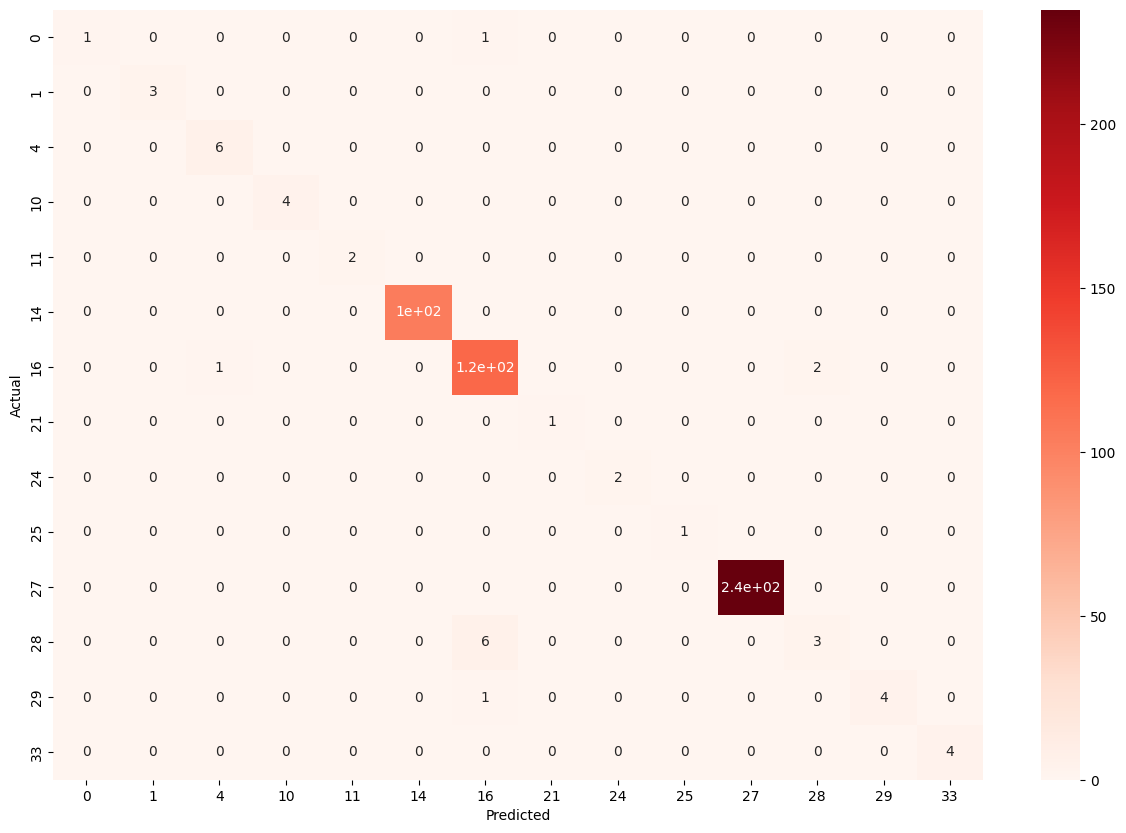


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      1.00      1.00         3
           4       0.86      1.00      0.92         6
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         2
          14       1.00      1.00      1.00       104
          16       0.94      0.98      0.96       122
          21       1.00      1.00      1.00         1
          24       1.00      1.00      1.00         2
          25       1.00      1.00      1.00         1
          27       1.00      1.00      1.00       235
          28       0.60      0.33      0.43         9
          29       1.00      0.80      0.89         5
          33       1.00      1.00      1.00         4

    accuracy                           0.98       500
   macro avg       0.96      0.90      0.92       500
weighted avg       0.98      0.98      0.98       500

A

In [87]:
common.evaluate(y_test_df, svm_predictions_actual_df, heading='SVM Evaluation (for all)')